# Titanic Kaggle Competition Solution

### Importing the Training and Test data from CSV files

In [1]:
from collections import Counter 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Project Midas/Competition'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('../Competition/train.csv')
test = pd.read_csv('../Competition/test.csv')
IDtest = test["PassengerId"]

### Detecting Outliers in the Age, SibSp, Parch, Fare Features

In [2]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [3]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### Combine Dataset to apply feature engineering techniques evenly on the datasets

In [4]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### Create New feature 'Title' from 'Name' and group them under 4 major titles - Mr, Mrs, Miss, Master

In [5]:
#Create Title from Name feature
def create_title(data):
  data["Title"] = data["Name"].map(lambda x:x.split(',')[1].split('.')[0].strip())
  return data

dataset = create_title(dataset)

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
dataset['Title']=dataset.apply(replace_titles, axis=1)

### Transform Feature "Sex" as Male: '1' & Female: '0'

In [6]:
SX = LabelEncoder()

dataset['Sex'] = SX.fit_transform(dataset.Sex)

### Dropping Name feature from the Feature set

In [7]:
#Dropping Name column
dataset = dataset.drop(['Name'], axis =1)

### Filling the missing Embarked feature

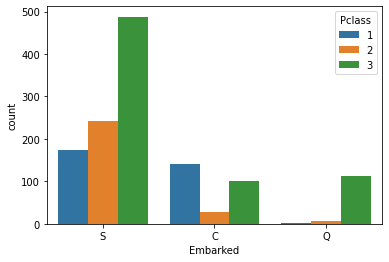

In [8]:
#Countplot of Passenger by Port of Embarkation by class 
g = sns.countplot(x="Embarked", hue = "Pclass", data=dataset)

In [9]:
#Fill the missing Port of Embarkation with Mode Function
dataset["Embarked"].fillna(dataset["Embarked"].mode()[0],inplace=True)

### Filling the Missing Age values

In [11]:
# Filling missing value of Age 
# Fill Age with the median age of similar rows according to Title
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][(dataset['Title'] == dataset.iloc[i]["Title"])].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

In [12]:
#Fill the missing Fare with Median value
dataset["Fare"].fillna(dataset.groupby("Pclass")["Fare"].transform("median"),inplace=True)

### Feature Engineering - Creating New Features

In [46]:
# Create Deck Feature from Cabin
dataset["Deck"] = dataset["Cabin"].str[0]

# Filling missing value of Deck 
# Fill Deck with the median value of similar rows according to Pclass
# Index of NaN deck rows
index_NaN_deck = list(dataset["Deck"][dataset["Deck"].isnull()].index)

for i in index_NaN_deck :
    deck_med = dataset["Deck"].mode()[0]
    deck_pred = dataset["Deck"][(dataset['Pclass'] == dataset.iloc[i]["Pclass"])].mode()[0]
    if not np.isnan(age_pred) :
        dataset['Deck'].iloc[i] = deck_pred
    else :
        dataset['Deck'].iloc[i] = deck_med

In [47]:
# Creating new features from Deck Column
dataset['Deck_A'] = dataset['Deck'].map(lambda s: 1 if s == 'A' else 0)
dataset['Deck_B'] = dataset['Deck'].map(lambda s: 1 if s == 'B' else 0)
dataset['Deck_C'] = dataset['Deck'].map(lambda s: 1 if s == 'C' else 0)
dataset['Deck_D'] = dataset['Deck'].map(lambda s: 1 if s == 'D' else 0)
dataset['Deck_E'] = dataset['Deck'].map(lambda s: 1 if s == 'E' else 0)
dataset['Deck_F'] = dataset['Deck'].map(lambda s: 1 if s == 'F' else 0)
dataset['Deck_G'] = dataset['Deck'].map(lambda s: 1 if s == 'G' else 0)
dataset['Deck_X'] = dataset['Deck'].map(lambda s: 1 if s == 'X' else 0)

#Dropping Fare feature
dataset = dataset.drop(['Deck'], axis =1)

In [48]:
# Create family size feature from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"]

#Dropping Fare feature
#dataset = dataset.drop(['SibSp'], axis =1)
#dataset = dataset.drop(['Parch'], axis =1)

In [49]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [50]:
# Create New Feature - Gender & Class

dataset['GClass'] = dataset['Sex'].map(lambda s: 1 if s == 0 else 0) * (1/dataset['Pclass'])

In [51]:
# Create New Feature - Age & Gender

dataset['GenderAge'] = dataset['Sex'].map(lambda s: 1 if s == 0 else 0) * (1/dataset['Age'])

In [52]:
# Create new features - First, Second & Third Class off of PClass
dataset['First'] = dataset['Pclass'].map(lambda s: 1 if s == 1 else 0)
dataset['Second'] = dataset['Pclass'].map(lambda s: 1 if  s == 2  else 0)
dataset['Third'] = dataset['Pclass'].map(lambda s: 1 if s >= 3  else 0)

#Dropping Pclass column
dataset = dataset.drop(['Pclass'], axis =1)

In [53]:
# Create new features - Fare Ranges off of Fare Feature
dataset['FreeTicket'] = dataset['Fare'].map(lambda s: 1 if s == 0 else 0)
dataset['Lowest_Fare'] = dataset['Fare'].map(lambda s: 1 if (s >= -2 and s < 10) else 0)
dataset['Low_Fare'] = dataset['Fare'].map(lambda s: 1 if (s >= 10 and s < 25) else 0)
dataset['Medium_Fare'] = dataset['Fare'].map(lambda s: 1 if (s >= 25 and s < 35) else 0)
dataset['MHigh_Fare'] = dataset['Fare'].map(lambda s: 1 if (s >= 35 and s < 100) else 0)
dataset['High_Fare'] = dataset['Fare'].map(lambda s: 1 if (s >= 100 and s < 300) else 0)
dataset['Highest_Fare'] = dataset['Fare'].map(lambda s: 1 if s >= 300 else 0)

#Dropping Fare feature
dataset = dataset.drop(['Fare'], axis =1)

In [54]:
# Create new features - Age bands off of Age Feature
dataset['Infant'] = dataset['Age'].map(lambda s: 1 if (s >= 0 and s < 4) else 0)
dataset['Toddler'] = dataset['Age'].map(lambda s: 1 if (s >= 4 and s < 12) else 0)
dataset['Teens'] = dataset['Age'].map(lambda s: 1 if (s >= 12 and s < 18) else 0)
dataset['Young Adult'] = dataset['Age'].map(lambda s: 1 if (s >= 18 and s < 25) else 0)
dataset['Adult'] = dataset['Age'].map(lambda s: 1 if (s >= 25 and s < 35) else 0)
dataset['Adult+'] = dataset['Age'].map(lambda s: 1 if (s >= 35 and s < 45) else 0)
dataset['Middle_Aged'] = dataset['Age'].map(lambda s: 1 if (s >= 45 and s < 60) else 0)
dataset['Seniors'] = dataset['Age'].map(lambda s: 1 if (s >= 60 and s < 70) else 0)
dataset['Seniors+'] = dataset['Age'].map(lambda s: 1 if (s >= 70) else 0)

#Dropping Age Feature
dataset = dataset.drop(['Age'], axis =1)

In [55]:
# Create new features based on port of Embarkation
dataset['Em_C'] = dataset['Embarked'].map(lambda s: 1 if s == 'C' else 0)
dataset['Em_Q'] = dataset['Embarked'].map(lambda s: 1 if s == 'Q' else 0)
dataset['Em_S'] = dataset['Embarked'].map(lambda s: 1 if s == 'S' else 0)


#Dropping Embarked Column
dataset = dataset.drop(['Embarked'], axis =1)

In [56]:
# Create new features based on Title
dataset['Mr'] = dataset['Title'].map(lambda s: 1 if s == 'Mr' else 0)
dataset['Mrs'] = dataset['Title'].map(lambda s: 1 if s == 'Mrs' else 0)
dataset['Miss'] = dataset['Title'].map(lambda s: 1 if s == 'Miss' else 0)
dataset['Master'] = dataset['Title'].map(lambda s: 1 if s == 'Master' else 0)

#Dropping Embarked Column
dataset = dataset.drop(['Title'], axis =1)

In [57]:
#Dropping Ticket column
dataset = dataset.drop(['Ticket'], axis =1)

In [58]:
#Dropping Cabin column
dataset = dataset.drop(['Cabin'], axis =1)

In [59]:
# Dropping Passenger Id
dataset = dataset.drop(['PassengerId'], axis =1)

In [61]:
## Separate out train and test data from dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [62]:
#Separate X_train & y_train from train dataframe

y_train = train["Survived"].astype(int)

X_train = train.drop(labels = ["Survived"],axis = 1)

In [63]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=30)

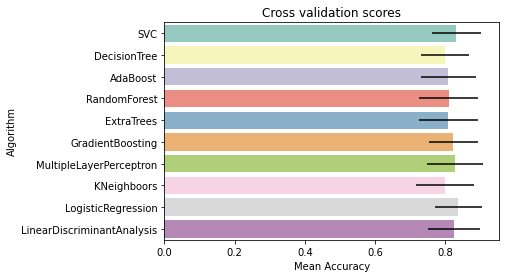

In [64]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=6))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [65]:
### META MODELING  WITH ADABOOST, RF, SVC, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
gsadaDTC.best_score_

Fitting 30 folds for each of 112 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1420 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:    5.4s finished


0.8087356321839079

In [66]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 30 folds for each of 54 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.2min finished


0.8334099616858238

In [67]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 30 folds for each of 54 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.2min finished


0.832145593869732

In [68]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 30 folds for each of 72 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   42.6s finished


0.824176245210728

In [69]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 30 folds for each of 28 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   22.4s finished


0.8309195402298851

In [70]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)

In [71]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

##### References

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
https://github.com/ishanbhandari-19/Titanic-Challenge/blob/master/PreProcessing_and_Feature_Engineering.ipynb
https://www.kaggle.com/soham1024/titanic-data-science-eda-solutions

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      881 non-null    float64
 1   Sex           1299 non-null   int64  
 2   SibSp         1299 non-null   int64  
 3   Parch         1299 non-null   int64  
 4   Deck_A        1299 non-null   int64  
 5   Deck_B        1299 non-null   int64  
 6   Deck_C        1299 non-null   int64  
 7   Deck_D        1299 non-null   int64  
 8   Deck_E        1299 non-null   int64  
 9   Deck_F        1299 non-null   int64  
 10  Deck_G        1299 non-null   int64  
 11  Deck_X        1299 non-null   int64  
 12  Fsize         1299 non-null   int64  
 13  Single        1299 non-null   int64  
 14  SmallF        1299 non-null   int64  
 15  MedF          1299 non-null   int64  
 16  LargeF        1299 non-null   int64  
 17  First         1299 non-null   int64  
 18  Second        1299 non-null 